## Udacity Self Driving NanoDegree Program

## Lane-Finding Project

When we drive, we use our eyes to decide where to go. The lines on the road that show us where the lanes are act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm.

In this project we are supposed to detect lane lines in images using Python and OpenCV. OpenCV means "Open-Source Computer Vision", which is a package that has many useful tools for analyzing images.

<img src="examples/laneLines_thirdPass.jpg" width="480" alt="Combined Image" />

### Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
from ipywidgets import interact, interactive, fixed

### Visualize Data

Let's first visualize the kind of images we are dealing with.

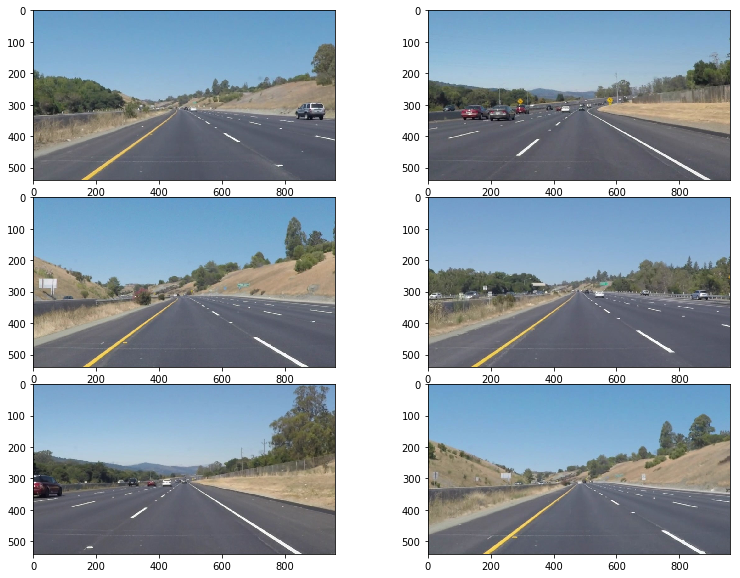

In [2]:
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(14,10))
fig.subplots_adjust(hspace = .1, wspace=.02)
axs = axs.ravel()

i=0
for img in test_images:
    img = mpimg.imread(img)
    axs[i].imshow(img)
    i+=1
    

### Strategy

1. Convert incoming images from RGB colorspace to HSV colorspace to make it more robust to varying lighting conditions.

<img src="screenshots/Selection_023.png" width="480" alt="Combined Image" />

2. Since the lane lines are yellow and white in color, perform a color masking for these colors in the HSV images to extract lane lines from the image and filter out the noise.

<img src="screenshots/Selection_024.png" width="480" alt="Combined Image" />

3. Perform canny edge detection on the resulting image.

<img src="screenshots/Selection_025.png" width="480" alt="Combined Image" />

4. Identify the area to search for lane lines (Hint: sky region would not be the area to look for lane lines). 

<img src="screenshots/Selection_026.png" width="480" alt="Combined Image" />

5. Get hough lines for the lane lines in our area of interest.

<img src="screenshots/Selection_027.png" width="480" alt="Combined Image" />

6. Get the original image masked by the hough lines.

<img src="screenshots/Selection_028.png" width="480" alt="Combined Image" />

## Helper Functions

In [7]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def convert_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    img = cv2.polylines(img, vertices, True, (0,255,255),3)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        
        #print('here')
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        #print('there')
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #algorithm logic:
    #aim is to find x_min, y_min, x_max, y_max , slope and intercept for both lanes lines.
    #for each line returned from the hough lines function:
    #   calculate slope
    #   calculate intercept
    #   store positive and negative slope and intercept values separately in arrays.
    #   y_min is the minimum of all the y coordinates.
    #   y_max is the bottom of the image from where the lane lines start.
    #   slope and intercept values for both lines are just the averages of all values stored previously.
    #  x_min and x_max can now be calculated by fitting all the lines in the equation x = (y - intercept)/slope.
    
    #LINE DISPLAY PARAMETERS
    color = [243, 105, 14]
    thickness = 12
    
    #LINE PARAMETERS
    SLOPE_THRESHOLD = 0.3
    Y_MIN_ADJUST = 15
    
    positive_slopes = []
    negative_slopes = []
    
    positive_intercepts = []
    negative_intercepts = []
    
    #named as y_max despte being at the bottom corner of the image due to y axis in reverse direction
    y_max = img.shape[0]
    y_min = img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #calculate slope for the line
            slope = (y2-y1)/(x2-x1)
            intercept = y2 - (slope*x2)
            
            #for negative slope
            if slope < 0.0 and slope > -math.inf and abs(slope) > SLOPE_THRESHOLD:
                #print('negative slope')
                negative_slopes.append(slope)
                negative_intercepts.append(intercept)
                
            #for positive slope
            elif slope > 0.0 and slope < math.inf and abs(slope) > SLOPE_THRESHOLD:
                #print('positive slope')
                positive_slopes.append(slope)
                positive_intercepts.append(intercept)
            
            y_min = min(y_min, y1, y2)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    y_min+=Y_MIN_ADJUST
    
    #get averages for positive and negative slopes
    positive_slope_mean = np.mean(positive_slopes)
    negative_slope_mean = np.mean(negative_slopes)

    #get averages for potitive and negative intercepts
    positive_intercept_mean = np.mean(positive_intercepts)
    negative_intercept_mean = np.mean(negative_intercepts)
    
    #calculation of coordinates for lane for positive slopes
    if len(positive_slopes) > 0:
        x_max = int((y_max - positive_intercept_mean)/positive_slope_mean)
        x_min = int((y_min - positive_intercept_mean)/positive_slope_mean)
        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    #calculation of coordinates for lane for negative slopes
    if len(negative_slopes) > 0:
        x_max = int((y_max - negative_intercept_mean)/negative_slope_mean)
        x_min = int((y_min - negative_intercept_mean)/negative_slope_mean)
        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
           

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#GAUSSIAN BLUR PARAMETERS
KERNEL_SIZE = 3

#CANNY EDGE DETECTION PARAMETERS
LOW_THRESHOLD = 75 
HIGH_THRESHOLD = 150 

#REGION OF INTEREST PARAMETERS
H_CONST = 0.08
RIGHT_LANE_SLOPE = 14/32
RIGHT_LANE_CONST = 400
TOP_SHIFT_H = 40 
TOP_SHIFT_V = 40

#HOUGH LINES PARAMETERS
RHO = 3.5 
THETA = np.pi/180
MIN_VOTES = 30    
MIN_LINE_LEN = 5 
MAX_LINE_GAP= 25  
LOWER_EDGE = 800


def get_region_of_interest_vertices(img):
    
    #get image parameters for extracting the region of interest
    img_height = img.shape[0]
    img_width = img.shape[1]

    bottom_left = (img_width/9 - H_CONST*img_width, img_height)
    top_left = (img_width / 2 - (TOP_SHIFT_H ), img_height / 2 + TOP_SHIFT_V)
    top_right = (img_width /2 + TOP_SHIFT_H, img_height/2 + TOP_SHIFT_V)
    bottom_right = (img_width - (RIGHT_LANE_SLOPE*img_width-RIGHT_LANE_CONST) + 
                         (H_CONST*img_width), img_height)
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
                        
    #print ('vertices-->', vertices)
    return vertices
    


def build_mask_pipeline(img):
    
    #gray out the image
    gray_img = convert_to_hsv(img)
   
    #smoothen the image
    smooth_img = gaussian_blur(gray_img, KERNEL_SIZE)
    
    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    
    mask_yellow = color_mask(smooth_img,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(smooth_img,white_hsv_low,white_hsv_high)
    
    mask_img = cv2.bitwise_or(mask_yellow,mask_white) 
    
    #canny edge detection
    canny_img = canny(mask_img, LOW_THRESHOLD, HIGH_THRESHOLD)
     
    #vertices for extracting desired portion from the image
    vertices = get_region_of_interest_vertices(img)
    
    #poly_img = cv2.polylines(img, vertices, True, (0,255,255),3)
   
    #get portion corresponding to the region of interest from the image
    regions = region_of_interest(canny_img, vertices)
    
    return regions 

def build_mask_complete_pipeline(img):
    
    #gray out the image
    gray_img = convert_to_hsv(img)
   
    #smoothen the image
    smooth_img = gaussian_blur(gray_img, KERNEL_SIZE)
    
    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    
    mask_yellow = color_mask(smooth_img,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(smooth_img,white_hsv_low,white_hsv_high)
    
    mask_img = cv2.bitwise_or(mask_yellow,mask_white) 
    
    #canny edge detection
    canny_img = canny(mask_img, LOW_THRESHOLD, HIGH_THRESHOLD)
     
    #vertices for extracting desired portion from the image
    vertices = get_region_of_interest_vertices(img)
    
    #poly_img = cv2.polylines(img, vertices, True, (0,255,255),3)
   
    #get portion corresponding to the region of interest from the image
    regions = region_of_interest(canny_img, vertices)
    
    #get hough lines for the lanes found in the img
    hough_img = hough_lines(regions, RHO, THETA, MIN_VOTES, MIN_LINE_LEN, MAX_LINE_GAP)

    #return original image masked by the hough lines 
    return weighted_img(hough_img, img)
    

### Helper functions for Visualization

In [18]:
def load_images(image_type):
    if image_type == 'test':
        glob_regex = 'test_images/*.jpg'
    elif image_type == 'challenge':
        glob_regex = 'challenge_images/*.jpeg'
    else:
        print('Invalid Type')
        return
    images=[]
    for f in glob.glob(glob_regex):
  
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images


def visualize_transformation(images):
    n = len(images)
    
    def view_image(i):
        file, img = images[i]
        
        canny_img = build_mask_pipeline(img)
        
        dst_img = build_mask_complete_pipeline(img)
            
        # Visualize transformation
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(canny_img, cmap = 'gray')
        ax2.set_title('Canny Image', fontsize=30)
        ax3.imshow(dst_img)
        ax3.set_title('Final Image', fontsize=30)
        
    interact(view_image, i=(0,n-1))

### Visualize Pipeline on Test Images

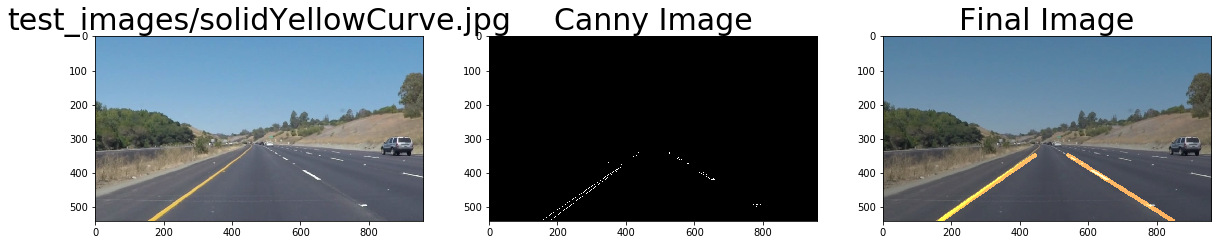

In [19]:
images = load_images('test')
visualize_transformation(images)

### Visualize Pipeline on Challenge Video Images

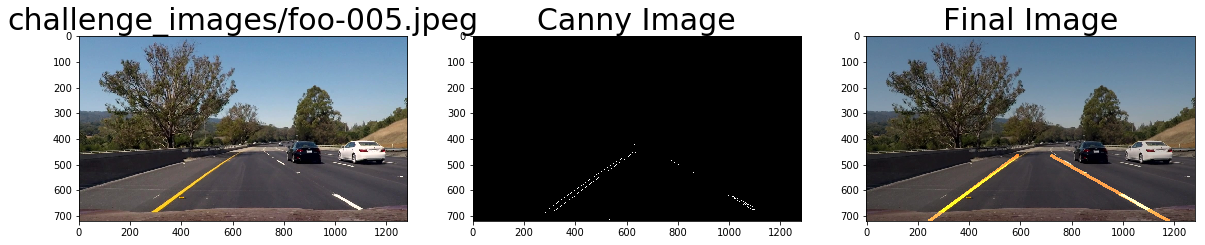

In [20]:
images = load_images('challenge')
visualize_transformation(images)

## Test on Videos

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = build_mask_complete_pipeline(image)
    return result

### Test Video 1

Let's try the one with the solid white lane on the right first ...

In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:09<00:00, 22.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 17.2 s, sys: 172 ms, total: 17.4 s
Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Test Video 2

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:30<00:00, 22.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 52.1 s, sys: 624 ms, total: 52.7 s
Wall time: 31.4 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Challenge Video

In [27]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:17<00:00, 13.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 23.4 s, sys: 404 ms, total: 23.8 s
Wall time: 18.8 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))